# GDELT initial findings from articles in January 2020

Author: Mike Pesavento  
Email: mike@peztek.com  
Date: 2020-06-29  


This report isolates and mines the [GDELT collection of news articles](https://blog.gdeltproject.org/a-new-contextual-dataset-for-exploring-climate-change-narratives-6-3m-english-news-urls-with-contextual-snippets-2015-2020/) containing information on climate change.  This collection consists of roughly 1 million articles spanning 5 years, from 2015 to 2020.

As a preliminary study, we use the (Argument Unit Recognition and Classification)[https://aaai.org/Papers/AAAI/2020GB/AAAI-TrautmannD.7498.pdf] (RESTful API)[https://api.argumentsearch.com/en/doc] to scrape sentences from the given articles and classify them as being PRO (for) or CONTRA (against) the given topic key words.

For the purposes here, we will focus on the keyword `climate change`, and use the API's similarity score based on the [`word2vec`](https://en.wikipedia.org/wiki/Word2vec) class of models for identifying word similarity. 


## Goals

1. Use the API to extract sentences from the first 1000 URLs, along with the model's classification of PRO or CONTRA for each sentence
1. Examine the distribution of articles FOR and AGAINST the given topic. If an article has more sentences PRO than CONTRA we claim the article is FOR the topic, and vice versa.



In [1]:
# reload local package definitions for each cell
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time

from dotenv import find_dotenv, load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from arg_mine import DATA_DIR, FIGURES_DIR
from arg_mine.data import loaders, labelers
from arg_mine.api import classify, auth, session, errors
from arg_mine import utils

sns.set_style("whitegrid")

/usr/local/lib/python3.8/site-packages/grequests.py:22: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.contrib.pyopenssl (/usr/local/lib/python3.8/site-packages/urllib3/contrib/pyopenssl.py)']. 
  curious_george.patch_all(thread=False, select=False)


In [3]:
# load the 2020 context snippet, for access later
csv_datapath = os.path.join(DATA_DIR, "raw", "2020-climate-change-narrative")
csv_filepath = os.path.join(csv_datapath, "WebNewsEnglishSnippets.2020.csv")

url_df = loaders.get_gdelt_df(csv_filepath)

INFO:2020-07-09 21:05:10,396:arg_mine.data.loaders: reading data from: /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2020.csv


In [4]:
start_time = time.time()
base_path = os.path.join(DATA_DIR, "processed", "gdelt-climate-change-docs")
docs_df = loaders.concat_csvs("gdelt_2020_docs_docs*.csv", base_path)

##  This line takes a long time! adds around 7 minutes to the load
# sentences_df = loaders.concat_csvs("gdelt_2020_sentences_docs*.csv", base_path)

# # need to drop empty sentences!
# sentences_df.dropna(subset=['sentence_original'], inplace=True)

# # add the context labels
# sentences_df = labelers.label_gdelt_context(url_df, docs_df, sentences_df)

print("data load and concatenation took {:0.1f} s".format(time.time() - start_time))

data load and concatenation took 0.1 s


## First finding: data attrition & descriptive stats
As expected, we find that there is some loss of data from the URL extraction. For example, some URLs point to articles that are no longer accessible, returning a 404 (page not found) error. This accounts for the overwhelming majority of the missing data.

In [5]:
total_number_articles = 10000  # from the current extraction
percent_data_loss = (1 - docs_df.shape[0]/total_number_articles) * 100
print("Number of valid articles: {}/{}  ({:0.2f}% data loss)".format(
    docs_df.shape[0],
    total_number_articles,
    percent_data_loss
))

Number of valid articles: 7460/10000  (25.40% data loss)


In [6]:
sentence_ct_cols = ['total_classified_sentences', 'total_arguments', 'total_non_arguments', 'total_contra_arguments', 'total_pro_arguments']

print("Total number of classified sentences: {}".format(docs_df['total_classified_sentences'].sum()))

docs_df[sentence_ct_cols].describe()

Total number of classified sentences: 314263


,total_classified_sentences,total_arguments,total_non_arguments,total_contra_arguments,total_pro_arguments
count,7460.000000,7460.000000,7460.000000,7460.000000,7460.000000
mean,42.126408,9.134718,32.991689,5.819839,3.314879
std,68.995005,11.436949,62.894992,8.274904,4.718278
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,12.000000,1.000000,0.000000
50%,30.000000,6.000000,21.000000,3.000000,2.000000
75%,46.000000,13.000000,35.000000,8.000000,5.000000
max,2535.000000,328.000000,2468.000000,238.000000,93.000000


## Distribution of argument sentences

What is the density of sentences that are making an argument for or against the topic, given all of the classified sentences?

In [7]:
docs_df["pct_arg"] = docs_df.total_arguments / docs_df.total_classified_sentences

# estimate if doc is PRO or CON
docs_df["is_pro"] = docs_df['total_pro_arguments'] > docs_df['total_contra_arguments']

Text(0, 0.5, '# of documents')

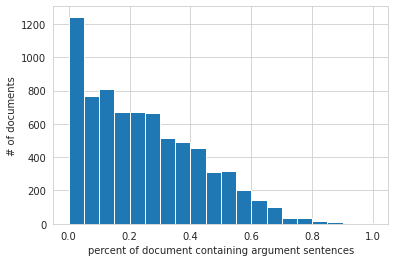

In [8]:
docs_df["pct_arg"].hist(bins=20)
plt.xlabel("percent of document containing argument sentences")
plt.ylabel("# of documents")

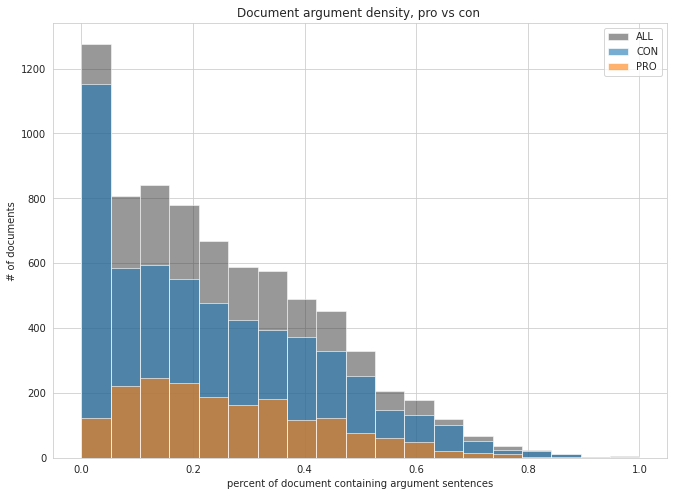

In [9]:
fig, ax = plt.subplots(figsize=(11, 8))
alpha=0.6
bins=np.linspace(0, 1, 20)
plt.hist(docs_df["pct_arg"], bins=bins, color=[0.2, 0.2, 0.2], alpha=0.5, label="ALL")
plt.hist(docs_df.loc[~docs_df["is_pro"], "pct_arg"], bins=bins, alpha=alpha, label="CON")
plt.hist(docs_df.loc[docs_df["is_pro"], "pct_arg"], bins=bins, alpha=alpha, label="PRO")
plt.xlabel("percent of document containing argument sentences")
plt.ylabel("# of documents")
plt.title("Document argument density, pro vs con ")
plt.legend()
fig.savefig(os.path.join(FIGURES_DIR, "doc_arg_density_1000docs_Jan2020.png"))

## Number of arguments by hostname

In [10]:
docs_df['netloc'] = utils.get_url_hostnames(docs_df.url)

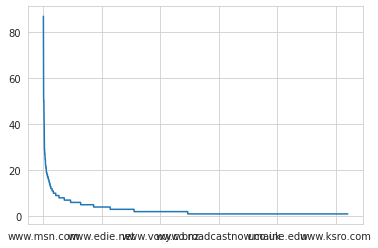

In [11]:
netloc_hist = docs_df.netloc.value_counts()
netloc_hist.plot(kind="line")

# Spot-check on arguments
How do we check whether a sentence is a claim or an argument?

We have docs on this!
An argument is a combination of claims (2 or more). One of those claims is the premise, which justifies the conclusion.

Two types of statements. One is implied ("Climate change is occuring")

Argument is creating reasoning to justify conclusion.

A claim is any assertion of truth, fact or opinion, right or wrong. It implies the truth of something.

## What i need to do
Spot check is to detect whether a sentence is a argument or claim.
reason for argument is not valid if claim.

Get examples of claim and arg extraction from Jamie?
Read `Making Arguments` guide

Want to know accuracy of the API.
if is accurate at pulling out arguments & claims

We may have a labeled dataset as well
done so line by line!

Sentences are listed because claim or arugment can be derived from them.

* Jamie will share labeled dataset
There is a tag added that has "implied". These need to be omitted as a label.

